In [1]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
from healpy.newvisufunc import projview, newprojplot
import time
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

In [2]:
from my_functions import *

In [3]:
def dipole_prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 100
    params[1] = cube[1]/10 # 0 - 0.1
    params[2] = cube[2]*2*np.pi # 0 - 2pi
    
    c = cube[3] # 0 - 1, used to calculate theta below. 
    # Oliver uses 0 - 0.1, but this doesnt return theta between (0,pi), is it a typo or am i missing something else?
    params[3] = np.arccos(np.clip(1 - 2*c, -1, 1)) #Clipping to ensure we stay in the valid range
    
    return params
    
def dipole_likelihood(params):
    N_bar, D, l, b = params
    pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))).T
    dipole_vec = hp.ang2vec(b, l) # dipole vector in cartesian
    angles = pixel_angles(pixel_vec, dipole_vec)
    
    lambda_i = N_bar * (1 + D*np.cos(angles))
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

In [8]:
# nside = 64
# npix = hp.nside2npix(nside)

# m, lambda_ = dipole_sampling(nside, 1000, 0.007, np.pi/4, -np.pi/2)

# dipole_plotting(m, np.pi/4, -np.pi/2, title='Density Map in Galactic Coordinates', unit="Sample Density",
#         cmap='plasma')

# smoothed_map = compute_smooth_map(m, weights=None, angle_scale=1)

# dipole_plotting(smoothed_map, np.pi/4, -np.pi/2, title='Smoothed Density Map in Galactic Coordinates',
#         unit="Sample Density", cmap='plasma')


In [3]:
# NSIDE = 64
# NPIX = hp.nside2npix(NSIDE)
# dipole_param_names = [r'$\bar N$', 'D', r'$\ell$', 'b']

# # Define the Nbar values to test
# Nbars = [0.1, 0.5, 1.0, 2.0, 5, 10, 25, 50, 75, 100, 150, 200]
# total_counts = []
# time_taken = []

# for Nbar in Nbars:
#     start = time.time()
#     # Generate a dipole map with a given Nbar
#     m, lambda_ = dipole_sampling(NSIDE, Nbar, 0.007, np.pi/4, -np.pi/2)
#     count = np.sum(m)
#     total_counts.append(count)
#     print(f"Total counts for Nbar={Nbar}: {count}")
#     # Run the dipole nested sampler
#     dipole_sampler = ultranest.ReactiveNestedSampler(dipole_param_names, dipole_likelihood,
#                                                     dipole_prior_transform)
#     dipole_result = dipole_sampler.run()
#     end = time.time()

#     # Time taken to run the sampler
#     time_taken.append(end - start)
#     print(f"Time taken to run the sampler: {end - start:.3f} seconds")



In [4]:
# plt.figure(figsize=(8, 6))
# plt.plot(total_counts, time_taken, marker='o')
# plt.xscale('log')

# plt.xlabel('Total Counts')
# plt.ylabel('Time Taken (s)')
# plt.title('Time Taken vs Total Counts for Dipole Sampling')
# plt.savefig('../Figures/time_vs_counts_dipole.png', dpi=300)
# plt.show()

In [27]:
def quadrupole_prior_transform(cube):
    
    params = cube.copy()
    params[0] = cube[0]*200 # 0 - 2000 (Nbar)
    params[1] = cube[1]/5 # 0 - 0.2 (Q)
    params[2] = cube[2]*2*np.pi # 0 - 2pi (l1)
    
    c = cube[3] # 0 - 1, used to calculate theta below. 
    params[3] = np.arccos(np.clip(1 - 2*c, -1, 1)) #(b1)
    
    params[4] = cube[4]*2*np.pi # 0 - 2pi (l2)
    params[5] = np.arccos(np.clip(1 - 2*c, -1, 1)) #(b2)
    
    return params
    
def quadrupole_likelihood(params):
    N_bar, Q, l1, b1, l2, b2 = params
    
    pixels = hp.pix2vec(NSIDE, np.arange(NPIX))
    
    a = hp.ang2vec(b1, l1)
    b = hp.ang2vec(b2, l2)
    
    Q_prime = np.outer(a, b)
    Q_star = 1/2 * (Q_prime + Q_prime.T)
    Q_hat = Q_star - np.trace(Q_star)/3

    f = Q*np.einsum('ij,i...,j...', Q_hat, pixels, pixels)
    
    lambda_i = N_bar * (1 + f)

    return np.sum(poisson.logpmf(m, mu=lambda_i))

In [5]:
# NSIDE = 64
# NPIX = hp.nside2npix(NSIDE)
# quad_param_names = [r'$\bar N$', 'Q', r'$\ell_1$', r'$b_1$', r'$\ell_2$', r'$b_2$']

# # Define the Nbar values to test
# Nbars = [0.1, 0.5, 1.0, 2.0, 5, 10, 25, 50, 75, 100, 150, 200]
# total_counts_quad = []
# time_taken_quad = []
# vector_1 = [np.pi/2, -np.pi/3]
# vector_2 = [np.pi/4, np.pi/3]

# for Nbar in Nbars:
#     start = time.time()
#     # Generate a dipole map with a given Nbar
#     m, lambda_true_array = quadrupole_sampling(NSIDE=64,  N_bar=Nbar, Q=0.014, vector_1=vector_1, vector_2=vector_2)

#     count = np.sum(m)
#     total_counts_quad.append(count)
#     print(f"Total counts for Nbar={Nbar}: {count}")
#     # Run the dipole nested sampler

#     quad_sampler = ultranest.ReactiveNestedSampler(quad_param_names, quadrupole_likelihood,
#                                                quadrupole_prior_transform)

#     quad_sampler.stepsampler = ultranest.stepsampler.SliceSampler(
#         nsteps=10,
#         generate_direction = (ultranest.stepsampler.generate_mixture_random_direction))

#     quad_result = quad_sampler.run()
    
#     end = time.time()

#     # Time taken to run the sampler
#     time_taken_quad.append(end - start)
#     print(f"Time taken to run the sampler: {end - start:.3f} seconds")


In [6]:
# plt.figure(figsize=(8, 6))
# plt.plot(total_counts_quad, time_taken_quad, marker='o')
# plt.xscale('log')

# plt.xlabel('Total Counts')
# plt.ylabel('Time Taken (s)')
# plt.title('Time Taken vs Total Counts for Quadrupole Sampling')
# # plt.savefig('../Figures/time_vs_counts_quad.png', dpi=300)
# plt.show()

# Read in times from the cluster

In [6]:
# read in time taken from file
import os
pathname = '../log_dir/Dipole_and_Quadrupole_Data/'

subfolders = ['monopole_model/', 'dipole_model/', 'quadrupole_model/', 'dipole_quadrupole_model/']

data_dict = {'times': {}, 'Nbars': {}, 'D': {}, 'Q': {}, 'counts': {}}

for folder in subfolders:
    # use os to read in all txt files in the folder
    files = os.listdir(pathname + folder + 'times')
    for file in files:
        if file.endswith('.txt'):
            with open(pathname + folder + 'times/' + file, 'r') as f:
                lines = f.readlines()
                
                time = float(lines[0].strip())
                if folder == 'dipole_quadrupole_model/':
                    selected_file = '_'.join(file.split('_')[2:8])
                    data = 'skymap_data_'+selected_file+'.npy' # read in the skyamp
                    data = np.load(pathname + 'Datasets/Raw_Files/' + data,allow_pickle=True).item()
                    m = data['m']
                    count=sum(m)

                    Nbar = float(file.split('_')[3])
                    model = 'dipole_quadrupole'
                    D = float(file.split('_')[5])
                    Q = float(file.split('_')[7])
                else:
                    selected_file = '_'.join(file.split('_')[1:7])  # grab the relevant part of the filename for the dataset (skymap)                
                    data = 'skymap_data_'+selected_file+'.npy' # read in the skyamp
                    data = np.load(pathname + 'Datasets/Raw_Files/' + data,allow_pickle=True).item()
                    m = data['m']
                    count=sum(m)

                    Nbar = float(file.split('_')[2])
                    model = file.split('_')[0]
                    D = float(file.split('_')[4])
                    Q = float(file.split('_')[6])
                
                if model not in data_dict['times']:
                    data_dict['times'][model] = []
                    data_dict['Nbars'][model] = []
                    data_dict['D'][model] = []
                    data_dict['Q'][model] = []
                    data_dict['counts'][model] = []
                data_dict['times'][model].append(time)
                data_dict['Nbars'][model].append(Nbar)
                data_dict['D'][model].append(D)
                data_dict['Q'][model].append(Q)
                data_dict['counts'][model].append(count)
                

data_dict


{'times': {'monopole': [3.3770554065704346,
   4.312199354171754,
   3.7122581005096436,
   4.4047133922576975,
   4.1153297424316415,
   4.090582847595216,
   3.3877441883087167,
   3.7434232234954834,
   3.659609079360963,
   4.2105450630188,
   4.185594081878662,
   4.290170431137086,
   3.4135856628417973,
   3.743607282638551,
   3.3522717952728276,
   3.8134038448333745,
   4.185159206390382,
   3.9343557357788086,
   3.9219262599945073,
   3.946068286895753,
   3.726135015487672,
   3.8351941108703613,
   4.451929807662965,
   4.041142463684083,
   4.146740913391113,
   4.424318552017213,
   4.4236249923706055,
   3.9970433712005615,
   3.6324276924133376,
   4.006595134735107,
   3.8355934619903564,
   4.2261154651641855,
   4.3051843643188485,
   3.9221742153167725,
   3.9499118328094482,
   4.407222032546997,
   3.7914373874664307,
   4.168513774871826,
   3.6678707599639893,
   3.8535308837890625,
   4.0557007789611825,
   4.043755531311035,
   4.174116134643555,
   4.466649

/var/folders/7h/m7_4sh855rz0q0xk3d4dvg_00000gn/T/ipykernel_86999/465665657.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/var/folders/7h/m7_4sh855rz0q0xk3d4dvg_00000gn/T/ipykernel_86999/465665657.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


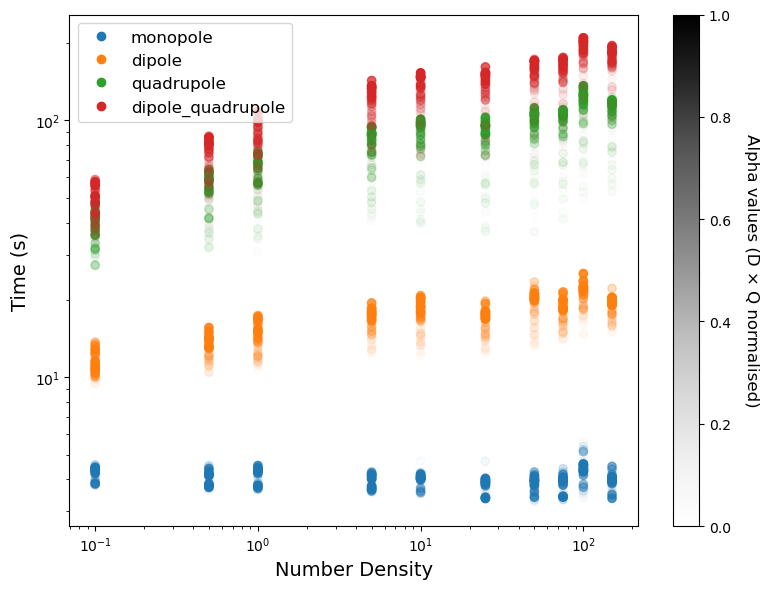

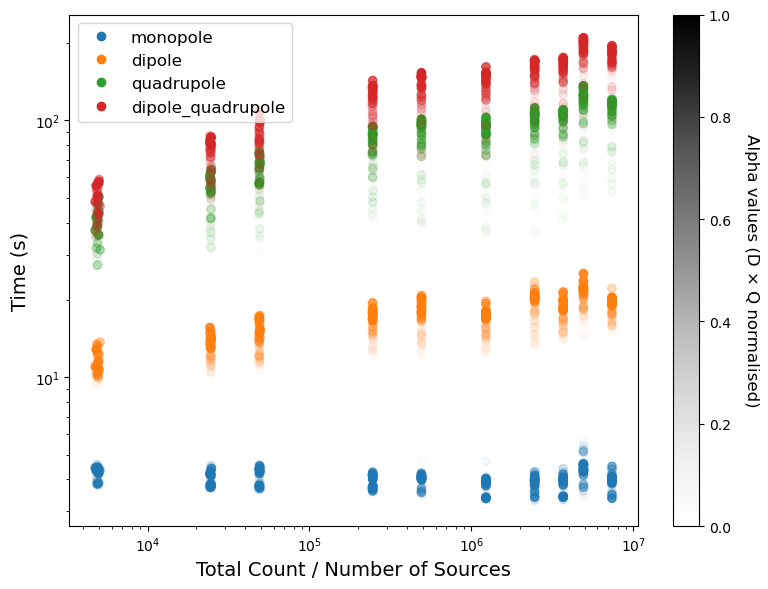

In [12]:

colors = {
    'monopole': 'tab:blue',
    'dipole': 'tab:orange',
    'quadrupole': 'tab:green',
    'dipole_quadrupole': 'tab:red'
}
legend_handles = []

plt.figure(figsize=(8, 6))
norm = Normalize(vmin=0, vmax=1)

for key in data_dict['times']:
    # plt.figure(figsize=(8, 6))
    d = np.array(data_dict['D'][key])
    q = np.array(data_dict['Q'][key])
    c = d * q  # element-wise multiplication
    c = c / np.max(c)  # normalize to [0, 1] for alpha values
    plt.scatter(data_dict['Nbars'][key], data_dict['times'][key], marker='o', alpha=c, label=key)
    
    legend_handles.append(Line2D([0], [0], marker='o', linestyle='',
                                 color=colors[key], label=key, alpha=1.0))


plt.xlabel('Number Density', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.legend(handles=legend_handles, fontsize=12)
sm = ScalarMappable(cmap = 'Greys', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Alpha values (D × Q normalised)', rotation=270, labelpad=20, fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../Figures/time_vs_Nbar_cluster_log.png', dpi=300)


colors = {
    'monopole': 'tab:blue',
    'dipole': 'tab:orange',
    'quadrupole': 'tab:green',
    'dipole_quadrupole': 'tab:red'
}
legend_handles = []

plt.figure(figsize=(8, 6))
norm = Normalize(vmin=0, vmax=1)

for key in data_dict['times']:
    # plt.figure(figsize=(8, 6))
    d = np.array(data_dict['D'][key])
    q = np.array(data_dict['Q'][key])
    c = d * q  # element-wise multiplication
    c = c / np.max(c)  # normalize to [0, 1] for alpha values
    plt.scatter(data_dict['counts'][key], data_dict['times'][key], marker='o', alpha=c, label=key)
    
    legend_handles.append(Line2D([0], [0], marker='o', linestyle='',
                                 color=colors[key], label=key, alpha=1.0))


plt.xlabel('Total Count / Number of Sources', fontsize=14)
plt.ylabel('Time (s)', fontsize=14)
plt.legend(handles=legend_handles, fontsize=12)
sm = ScalarMappable(cmap = 'Greys', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Alpha values (D × Q normalised)', rotation=270, labelpad=20, fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../Figures/time_vs_count_cluster_log.png', dpi=300)


This is ran on the cluster, paralllized over 24 cores with 20 Gb of memory.as_integer_ratio

Total walltime was about 34 hrs.

Likelihood functions are vectorised too, which drastically speeds up the process.

I want to try running unvectorised likelihood functions to see how much time it takes, and compare them (which will be good to include in a report that discusses time complexity)

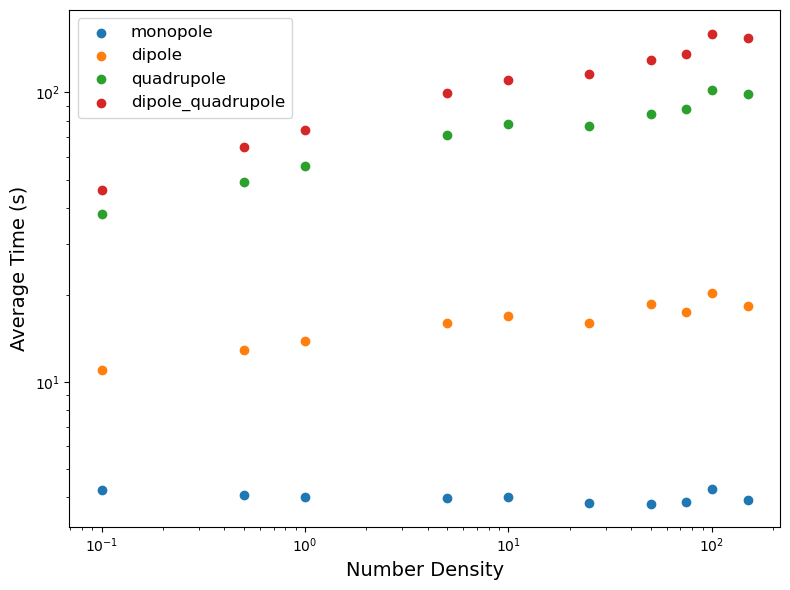

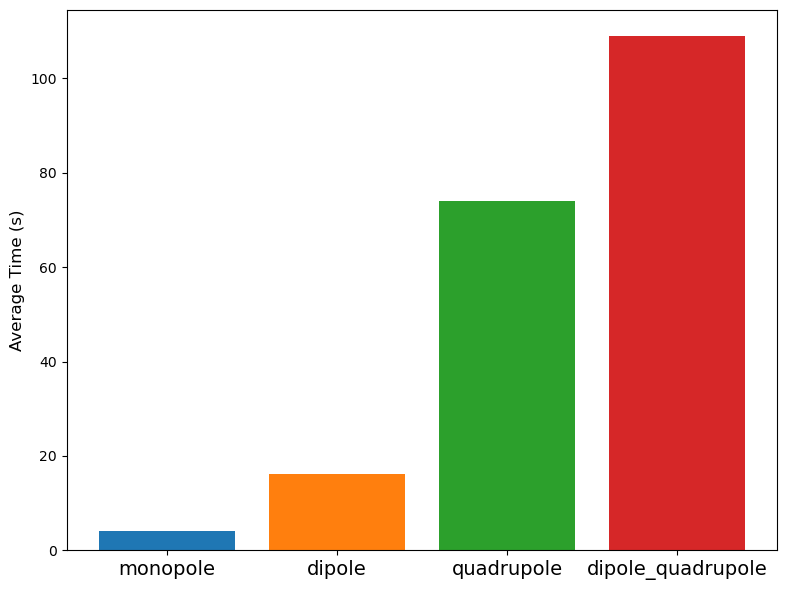

In [13]:
# now take average of the times for each model at a given Nbar
# and plot the average time taken for each model
# for each model, take the average time taken for each count and make a scatter plot (x axis = Nbar, y axis = average time taken)
avg_times = {}  
for key in data_dict['times']:
    avg_times[key] = {}
    for i in range(len(data_dict['Nbars'][key])):
        Nbar = data_dict['Nbars'][key][i]
        if Nbar not in avg_times[key]:
            avg_times[key][Nbar] = []
        avg_times[key][Nbar].append(data_dict['times'][key][i])
    for Nbar in avg_times[key]:
        avg_times[key][Nbar] = np.mean(avg_times[key][Nbar])
plt.figure(figsize=(8, 6))  
for key in avg_times:
    plt.scatter(avg_times[key].keys(), avg_times[key].values(), marker='o', label=key, color=colors[key])
plt.xlabel('Number Density', fontsize=14)
plt.ylabel('Average Time (s)', fontsize=14)
plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('../Figures/avg_time_vs_Nbar_cluster_log.png', dpi=300)
plt.show()


avg_times = {}
for key in data_dict['times']:
    avg_times[key] = np.mean(data_dict['times'][key])
plt.figure(figsize=(8, 6))
plt.bar(avg_times.keys(), avg_times.values(), color=[colors[key] for key in avg_times.keys()])
plt.xticks(fontsize=14)
plt.ylabel('Average Time (s)', fontsize=12)
plt.tight_layout()
# plt.savefig('../Figures/avg_time_vs_model_cluster.png', dpi=300)
plt.show()